In [ ]:
!pip install transformers

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import os

rc={'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 10.0,
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally
import seaborn as sns; sns.set()
sns.set_style("whitegrid")
mpl.rcParams['axes.linewidth'] = 0.0 #set the value globally

import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [ ]:
#@title Utilities

def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    for i in np.arange(1,n_layers+1):
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i-1)*length+k_t
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]

    return adj_mat, labels_to_index


def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_array(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner

        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')

    return G

def get_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner

        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')

    return G

def compute_flows(G, labels_to_index, input_nodes, length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in labels_to_index:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)

                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()

    return flow_values

def compute_node_flow(G, labels_to_index, input_nodes, output_nodes,length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in output_nodes:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()

    return flow_values

def compute_joint_attention(att_mat, add_residual=True):
    if add_residual:
        residual_att = np.eye(att_mat.shape[1])[None,...]
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(axis=-1)[...,None]
    else:
       aug_att_mat =  att_mat

    joint_attentions = np.zeros(aug_att_mat.shape)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0]
    for i in np.arange(1,layers):
        joint_attentions[i] = aug_att_mat[i].dot(joint_attentions[i-1])

    return joint_attentions

def plot_attention_heatmap(att, s_position, t_positions, sentence):

  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(['<cls>']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))

   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]

   return mats

## config

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = 'base'
nlayer = 12 if config == 'base' else 24
nsamples = 5000 if config == 'base' else 10000
pretrained_weights = 'bert-base-uncased'
model = AutoModelForMaskedLM.from_pretrained(pretrained_weights,
                                             output_hidden_states=True,
                                             output_attentions=True)
model.zero_grad()
tokenizer = AutoTokenizer.from_pretrained(pretrained_weights, use_fast=True)
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

## sentences to visualize

In [ ]:
sentences = {}
src = {}
targets = {}

sentences[0] = "The nurse phoned the doctor because "+tokenizer.mask_token+" was late"
src[0] = 8
targets[0] = (2,5)

sentences[1] = "The doctor phoned the nurse because "+tokenizer.mask_token+" was late"
src[1] = 8
targets[1] = (2,5)
#sentences[1] = "She asked the doctor about "+tokenizer.mask_token+" backache"
#targets[1] = (1,4)


sentences[2] = "The bell hop told the receptionist that "+tokenizer.mask_token+" could help the guest"
src[2] = 8
targets[2] = (2,3,6)

sentences[3] = "The receptionist told the bell hop that "+tokenizer.mask_token+" could help the guest"
src[3] = 8
targets[3] = (2,5,6)

sentences[4] = tokenizer.mask_token+" is the doctor here"
src[4] = 1
targets[4] = (1,2,3,4,5)

sentences[5] = tokenizer.mask_token+" is the nurse here"
src[5] = 1
targets[5] = (1,2,3,4,5)

In [ ]:
ex_id = 3
sentence = sentences[ex_id]
tokens = ['[CLS]']+tokenizer.tokenize(sentence)+['[SEP]']
print("token len & token: ",len(tokens), tokens)

encoding  = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=128,return_tensors="pt")
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
attention_mask[0][0] = 0
attention_mask[0][-1] = 0


model_output = model(
    input_ids
    ,attention_mask=attention_mask
    ,output_hidden_states=True
    ,output_attentions=True)
all_hidden_states, all_attentions  = model_output['hidden_states'], model_output['attentions']

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print("attentions_mat.shape",attentions_mat.shape)
# how many head?
# 12 layers, 12 heads, length,length
# mapping: [length,length]

output = model_output[0] # last hidden states ([1, 7, 30522])
predicted_target = torch.nn.Softmax()(output[0,src[ex_id]])

his_id = tokenizer.encode('he')[1]
her_id = tokenizer.encode('she')[1]

print(his_id, her_id)
print("his prob:", predicted_target[his_id].item(), "her prob:", predicted_target[her_id].item(), "her?", predicted_target[her_id].item() > predicted_target[his_id].item())

print("max prob id:",np.argmax(output.detach().numpy()[0][src[ex_id]], axis=-1))
print("max prob word:",tokenizer.decode(np.argmax(output.detach().numpy()[0][src[ex_id]], axis=-1)))

token len & token:  14 ['[CLS]', 'the', 'receptionist', 'told', 'the', 'bell', 'hop', 'that', '[MASK]', 'could', 'help', 'the', 'guest', '[SEP]']
attentions_mat.shape (12, 12, 14, 14)
2002 2016
his prob: 0.11077292263507843 her prob: 0.15618832409381866 her? True
max prob id: 2009
max prob word: it


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/MTminiproject/attention_flow-master
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/MTminiproject/attention_flow-master
 attention_graph_util.py			      'Copy of bert_example.ipynb'   __pycache__
 bert_example.ipynb				       correlation_logs		     README.md
 bert_sv.ipynb					       distilbert_sst.ipynb	     run_bert_sv.py
 bert_viz.ipynb					       distill_bert_viz.ipynb	     utils
 compute_corel_distilbert_sst.py		       graph
'Copy of attention_visualization_bert_example.ipynb'   graphs


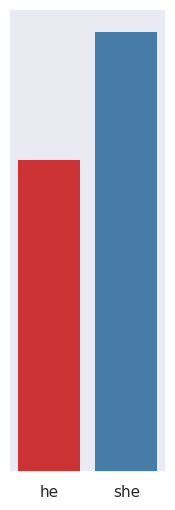

In [ ]:
fig = plt.figure(1,figsize=(2,6))
ax = sns.barplot(x=['he', 'she'], y=[ float(predicted_target[his_id].detach().numpy()),  float(predicted_target[her_id].detach().numpy())], linewidth=0, palette='Set1')
sns.despine(fig=fig, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax.set_yticks([])
plt.savefig('./graph/rat_bert_bar_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

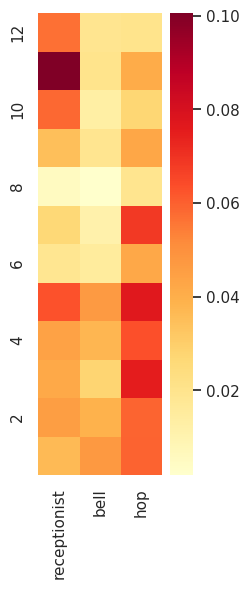

In [ ]:
plt.figure(1,figsize=(2,6))
plot_attention_heatmap(attentions_mat.sum(axis=1)/attentions_mat.shape[1], src[ex_id], t_positions=targets[ex_id], sentence=sentence)
plt.savefig('./graph/rat_bert_map_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

In [ ]:
#@title Get raw attention mat + residual coonections
# 1. average across head
raw_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
# 2. adding identity matrix to represent skip connection
res_att_mat = raw_att_mat + np.eye(raw_att_mat.shape[1])[None,...]
# 3. normalize by sentence
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)


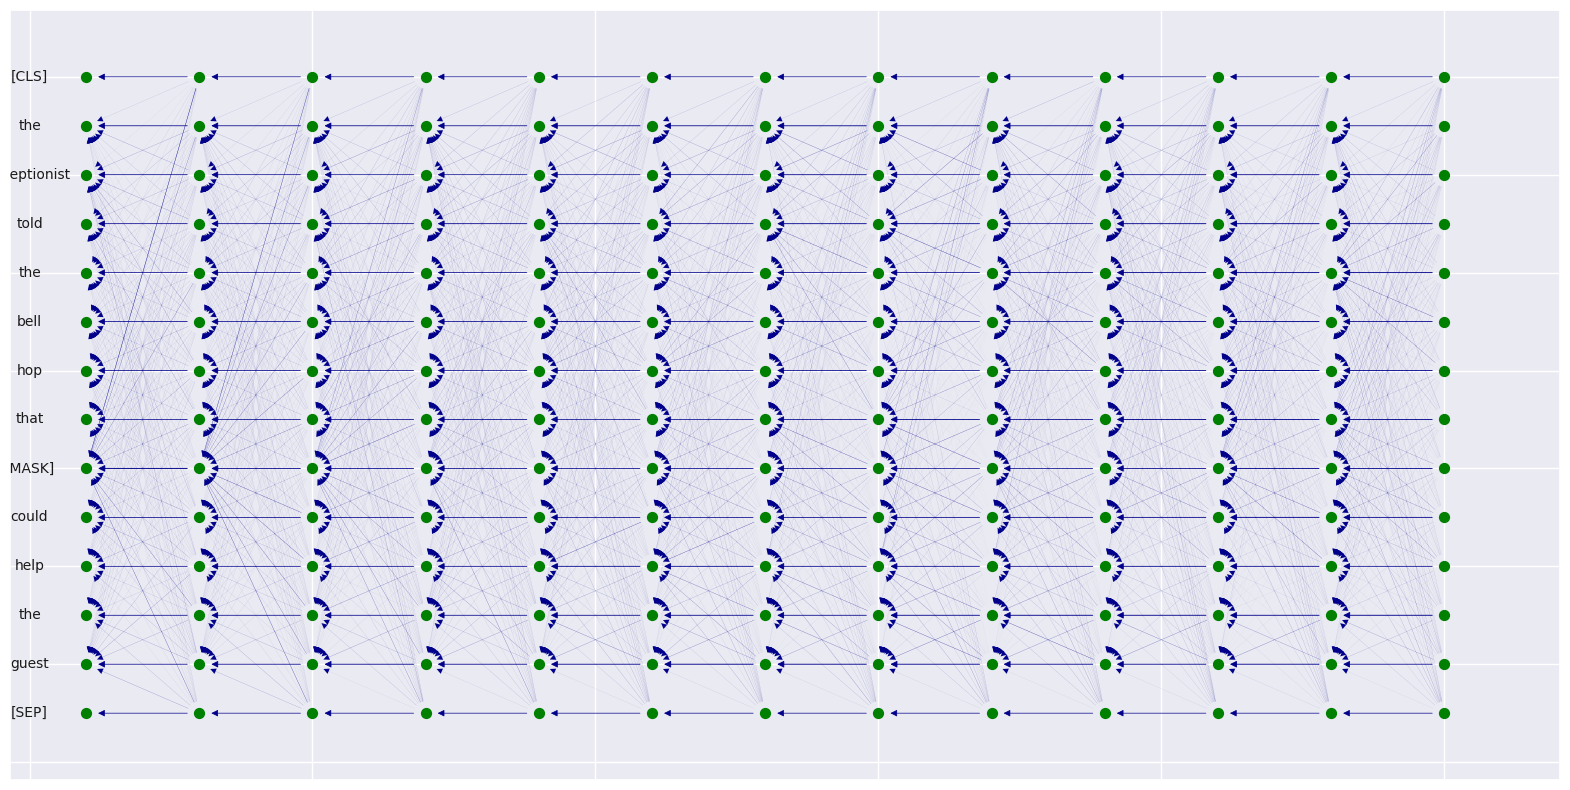

In [ ]:
#@title plot the attention graph
plt.figure(figsize=(20,10))
res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])
plt.savefig('./graph/res_bert_graph_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

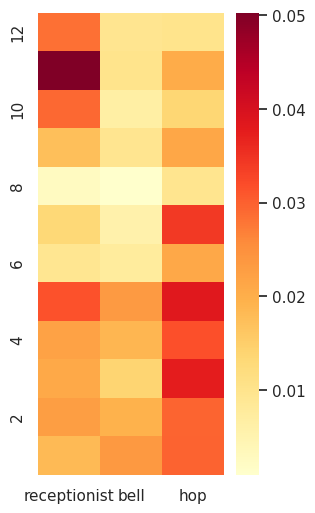

In [ ]:
#@title Plot contrastive heatmap

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(res_att_mat, src[ex_id], t_positions=targets[ex_id], sentence=sentence)
plt.savefig('./graph/res_bert_map_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

In [ ]:
#@title Compute attention rollout

joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)


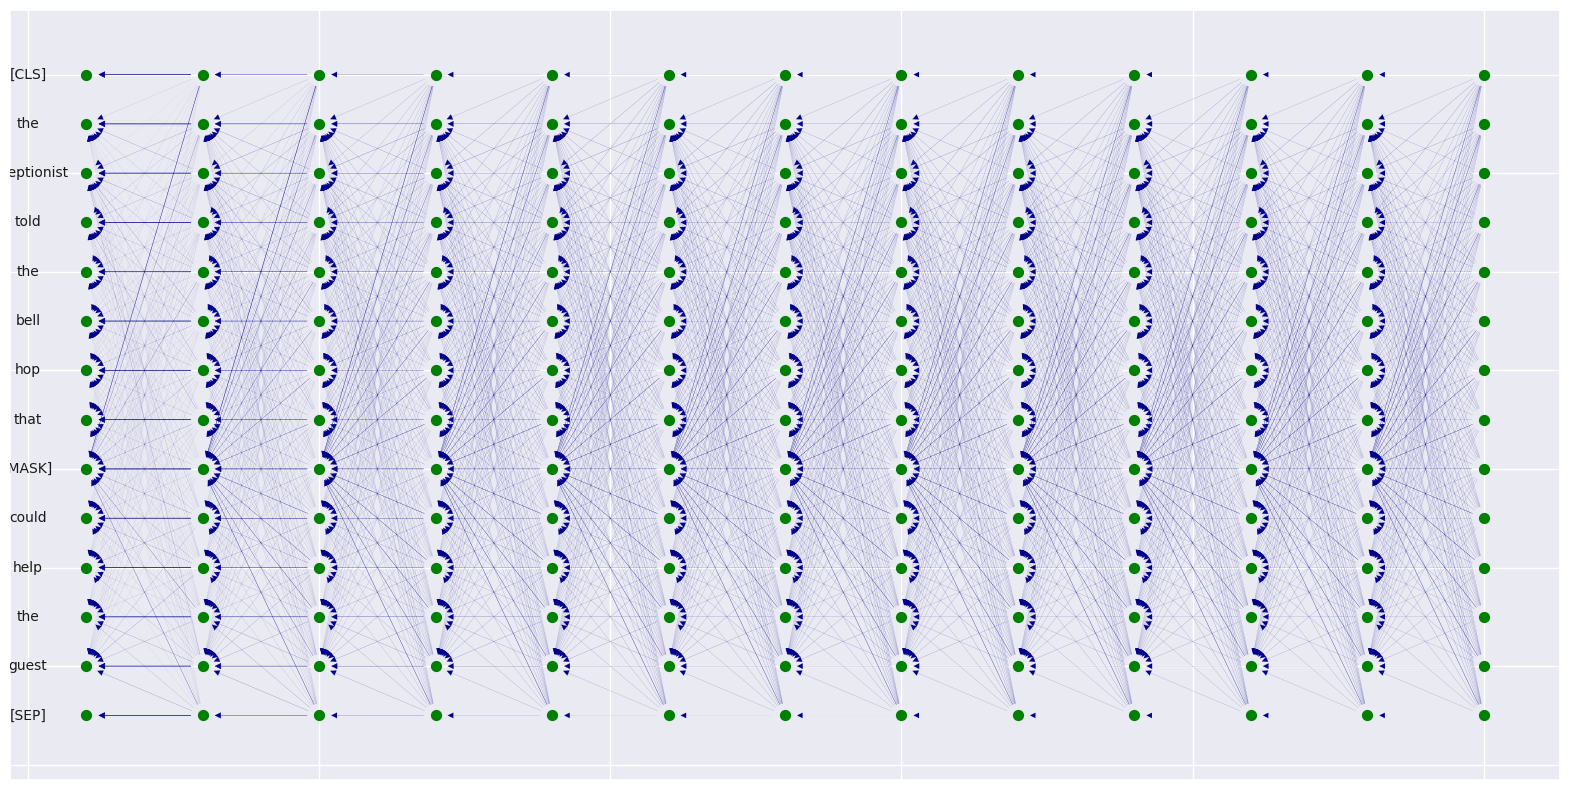

In [ ]:
#@title Draw attention rollout graph
plt.figure(figsize=(20,10))
G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])
plt.savefig('./graph/rollout_bert_graph_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

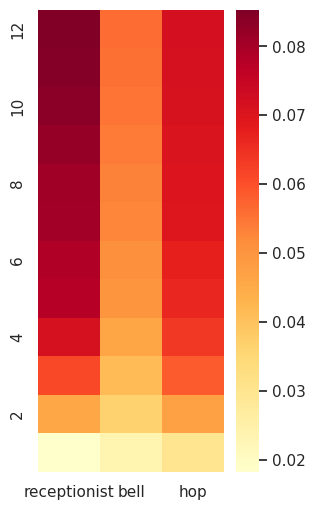

In [ ]:
#@title Plot contrastive heatmap

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(joint_attentions, src[ex_id], t_positions=targets[ex_id], sentence=sentence)
plt.savefig('./graph/roll_bert_map_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

In [ ]:
#@title Compute attention flow (this will take quite some time to compute).

output_nodes = []
input_nodes = []
for key in res_labels_to_index: # len 91 = 13 layers * 7 tokens 0-90, contain input, nodes with index
    if 'L24' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)
# input_nodes = ['0_[cls]', '1_[MASK]', '2_is', '3_the', '4_doctor', '5_here', '6_[sep]']
# attentions_mat (12,12,7,7)
flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1]) # (91,91)
# flow_values = [index_of_node,index_of_node]
# have been normalized for each row

In [ ]:
#flow_values[-7:]
num_tokens = attentions_mat.shape[-1]
num_layers = attentions_mat.shape[0]
skip_mat = np.zeros((num_tokens,num_layers-1))
for i in range(num_tokens):
  for j in range(num_layers-1):
    skip_mat[i][j] = flow_values[7*(j+2)+i][7*(j+1)+i]

skip_mat

array([[0.01424373, 0.        , 0.06726038, 0.        , 0.08097307,
        0.        , 0.07648496, 0.        , 0.07627328, 0.        ,
        0.07627328],
       [0.12774721, 0.        , 0.12361929, 0.        , 0.11355438,
        0.        , 0.09171111, 0.        , 0.09014869, 0.        ,
        0.09014869],
       [0.02349138, 0.        , 0.06591208, 0.        , 0.08041995,
        0.        , 0.0880935 , 0.        , 0.08635676, 0.        ,
        0.08635676],
       [0.04167229, 0.        , 0.06566537, 0.        , 0.06906675,
        0.        , 0.07905027, 0.        , 0.08364396, 0.        ,
        0.08364396],
       [0.02136019, 0.        , 0.04721111, 0.        , 0.0605305 ,
        0.        , 0.07445364, 0.        , 0.07363059, 0.        ,
        0.07363059],
       [0.03661957, 0.        , 0.06606666, 0.        , 0.07846971,
        0.        , 0.08382051, 0.        , 0.09014869, 0.        ,
        0.09014869],
       [0.        , 0.        , 0.        , 0.        , 0.

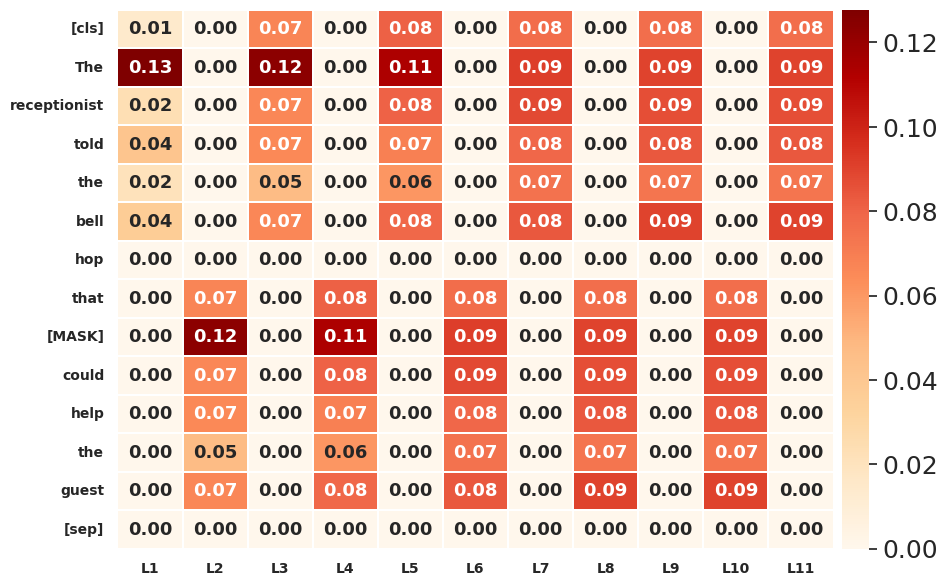

In [ ]:
# plotting heatmap
xticklabels=['L'+str(i+1) for i in range(11)]
yticklabels = ('[cls] '+sentence+" [sep]").split()

sns.set(font_scale=2)
sns.set(rc = {'figure.figsize':(11,7)})
ax = sns.heatmap(skip_mat, xticklabels = xticklabels, yticklabels=yticklabels,cmap="OrRd",
                 linewidths=0.1, annot=True, annot_kws={"fontsize":13, 'fontweight':'heavy'}, cbar_kws={"values":None, "location":'right',
                                                            "pad":0.01}, fmt='.2f', cbar = True)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10, fontweight = 'heavy')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10, fontweight = 'heavy')

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

fig = ax.get_figure()
fig.savefig('./graph/heatmap_skip_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

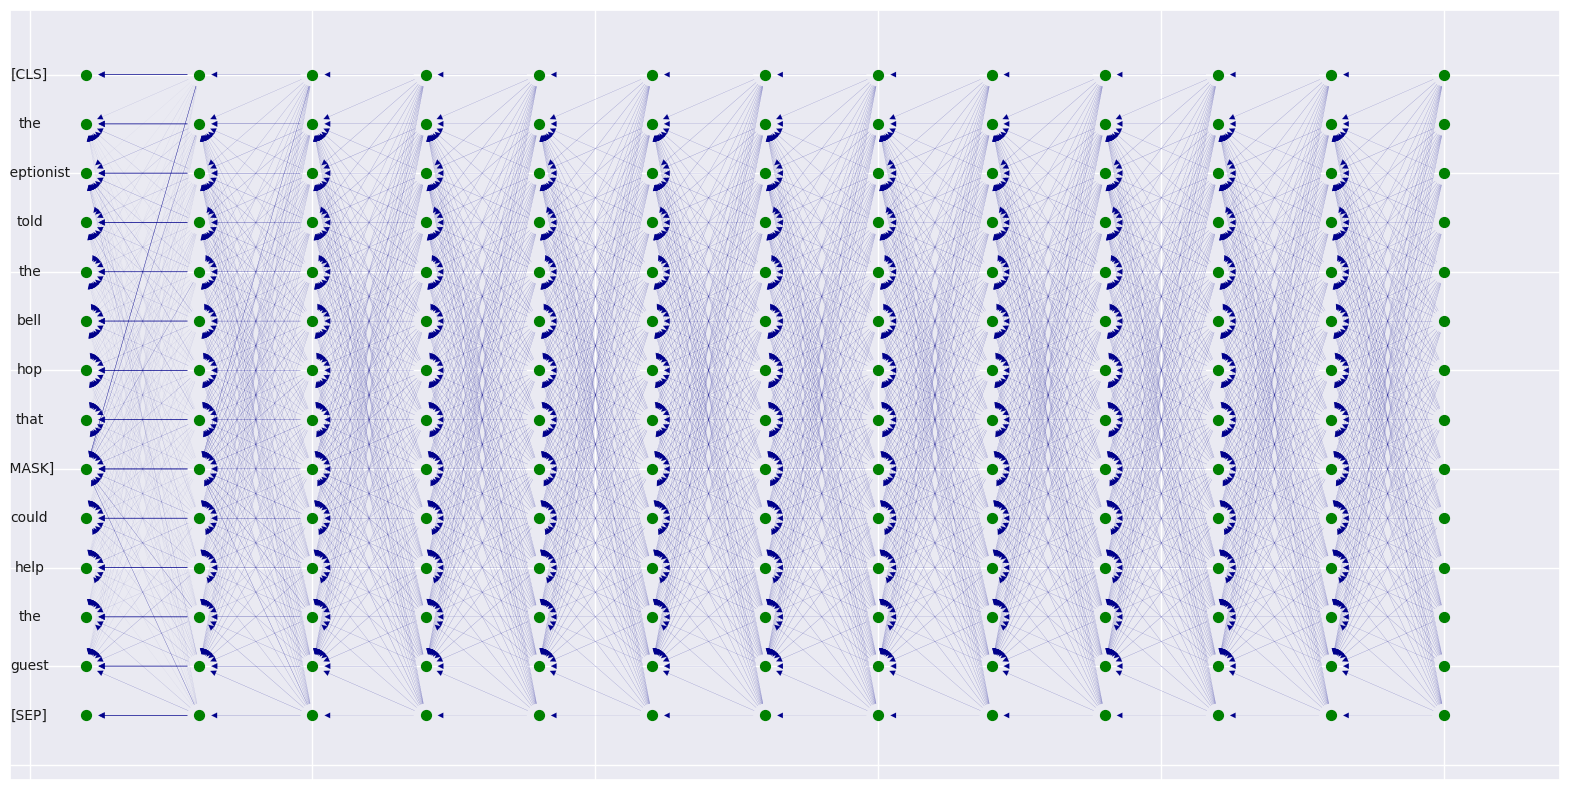

In [ ]:
#@title Draw attention flow graph

plt.figure(figsize=(20,10))
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('./graph/flow_bert_graph_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

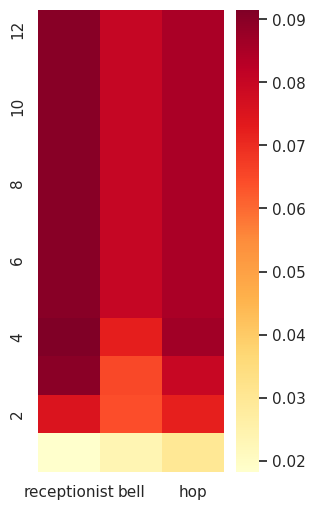

In [ ]:
#@title Plot contrastive heatmap
flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(flow_att_mat, src[ex_id], t_positions=targets[ex_id], sentence=sentence)
plt.savefig('./graph/flow_bert_map_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')